In [10]:
print("Hello World")

Hello World


In [2]:
import pulp as lp

def shortest_distance_lpp_with_osmids(G, s, t):
    # Collapse parallel edges to minimum length
    edges_minlen = {}
    best_key = {}
    for u, v, k, data in G.edges(keys=True, data=True):
        length = float(data.get("length", 0.0))
        if (u, v) not in edges_minlen or length < edges_minlen[(u, v)]:
            edges_minlen[(u, v)] = length
            best_key[(u, v)] = k

    E = list(edges_minlen.keys())

    # LPP
    prob = lp.LpProblem("ShortestPath", lp.LpMinimize)
    x = lp.LpVariable.dicts("x", E, 0, 1, cat=lp.LpBinary)

    prob += lp.lpSum(edges_minlen[e] * x[e] for e in E)

    nodes = list(G.nodes())
    for v in nodes:
        out_e = [e for e in E if e[0] == v]
        in_e = [e for e in E if e[1] == v]

        if v == s:
            prob += lp.lpSum(x[e] for e in out_e) - lp.lpSum(x[e] for e in in_e) == 1
        elif v == t:
            prob += lp.lpSum(x[e] for e in out_e) - lp.lpSum(x[e] for e in in_e) == -1
        else:
            prob += lp.lpSum(x[e] for e in out_e) - lp.lpSum(x[e] for e in in_e) == 0

    status = prob.solve(lp.PULP_CBC_CMD(msg=False))
    if lp.LpStatus[status] != "Optimal":
        raise ValueError("No optimal path found.")

    chosen = {(u, v) for (u, v) in E if lp.value(x[(u, v)]) > 0.5}

    # Reconstruct ordered node path
    node_path = [s]
    cur = s
    visited = {s}
    while cur != t:
        nxts = [v for (u, v) in chosen if u == cur]
        if not nxts:
            raise ValueError("Failed to reconstruct path.")
        nxt = nxts[0]
        if nxt in visited:
            raise ValueError("Cycle detected.")
        node_path.append(nxt)
        visited.add(nxt)
        cur = nxt

    # Ordered edges
    edge_path_uv = list(zip(node_path[:-1], node_path[1:]))
    edge_path_uvk = [(u, v, best_key[(u, v)]) for (u, v) in edge_path_uv]

    # Extract OSMIDs
    edge_osmids = []
    for u, v, k in edge_path_uvk:
        data = G.get_edge_data(u, v, k)
        osmid = data.get("osmid")
        if isinstance(osmid, list):
            edge_osmids.append(int(osmid[0]))
        else:
            edge_osmids.append(int(osmid))

    total_dist = sum(edges_minlen[(u, v)] for (u, v) in edge_path_uv)

    return node_path, edge_osmids, edge_path_uvk, total_dist


In [4]:
import osmnx as ox

G = ox.load_graphml("primary_secondary_tertiary_roads.graphml")

nodes = list(G.nodes())
s = nodes[0]
t = nodes[100]

node_path, osmids, edges_uvk, dist = shortest_distance_lpp_with_osmids(G, s, t)
print(node_path)
print(osmids)
print(edges_uvk)
print(dist)

[17327433, 429286716, 428853838, 1614268208, 3676198945, 3676198957, 12429482557, 2122621689, 11069723437, 2122621692, 461789657, 3632570061, 1436067882, 12099941385, 1307598719, 12099941393, 665045371, 10121158732, 10016225540, 11675668171, 254665655]
[148319042, 148319042, 148319042, 1104702857, 1104702861, 1104702861, 1259761693, 1246772715, 1246772715, 52242930, 52242930, 1267185545, 161416660, 458439812, 1035901180, 1035901181, 115837334, 26807972, 26807972, 1321561533]
[(17327433, 429286716, 0), (429286716, 428853838, 0), (428853838, 1614268208, 0), (1614268208, 3676198945, 0), (3676198945, 3676198957, 0), (3676198957, 12429482557, 0), (12429482557, 2122621689, 0), (2122621689, 11069723437, 0), (11069723437, 2122621692, 0), (2122621692, 461789657, 0), (461789657, 3632570061, 0), (3632570061, 1436067882, 0), (1436067882, 12099941385, 0), (12099941385, 1307598719, 0), (1307598719, 12099941393, 0), (12099941393, 665045371, 0), (665045371, 10121158732, 0), (10121158732, 10016225540, 

(array('d', [77.1696496, 77.1694055, 77.1688587]), array('d', [28.5515335, 28.5516813, 28.5520028]))
(array('d', [77.1688848, 77.1690199, 77.1692872, 77.1692957, 77.1693114, 77.1693321, 77.1695543, 77.1696658]), array('d', [28.5520406, 28.5522394, 28.5526425, 28.5526488, 28.5526502, 28.5526502, 28.552623, 28.5526028]))
(array('d', [77.1696658, 77.1696993, 77.1697509, 77.1697859, 77.1697896, 77.1697835, 77.1698771, 77.1699668, 77.1699801, 77.1700587, 77.1701617, 77.1703251]), array('d', [28.5526028, 28.552796, 28.5530207, 28.5532543, 28.5533703, 28.5535116, 28.5538192, 28.553985, 28.5540097, 28.5540049, 28.5539787, 28.5539412]))
(array('d', [77.1703251, 77.1703623, 77.1704136, 77.1704763, 77.1704858, 77.1704986]), array('d', [28.5539412, 28.5540769, 28.5542196, 28.5544013, 28.5544174, 28.5544308]))
(array('d', [77.1704986, 77.1705165, 77.17054, 77.1705635, 77.1705814, 77.170594, 77.1706419, 77.1706629, 77.1706863, 77.1707153, 77.1708018, 77.1708481, 77.1708798, 77.1709025, 77.1709685, 7

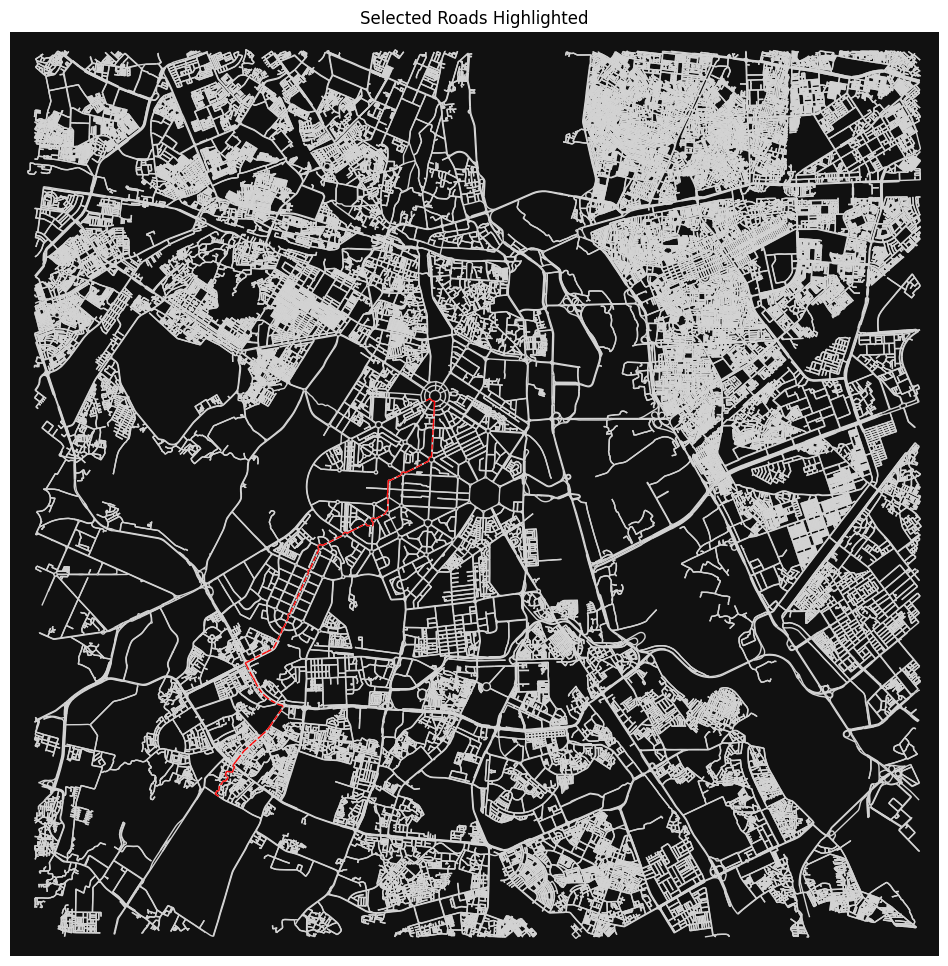

In [37]:
import matplotlib.pyplot as plt
ox.plot_graph(
    G,
    node_size=0,
    edge_color="lightgray",
    edge_linewidth=1,
    show=False,
    close=False,
    figsize=(12, 12)
)

for u, v, k in edges_uvk:
    data = G.edges[u, v, k]
    geom = data.get("geometry")

    if geom is not None:
        print(geom.xy)
        xs, ys = geom.xy
    else:
        xs = [G.nodes[u]["x"], G.nodes[v]["x"]]
        ys = [G.nodes[u]["y"], G.nodes[v]["y"]]

    plt.plot(xs, ys, c="red", linewidth=1, linestyle="dashed")

plt.title("Selected Roads Highlighted")
plt.savefig("highest_roads.svg", format="svg", bbox_inches="tight")
plt.savefig("highest_roads.png",)

plt.show()
